In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import Huber
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:

# Load data
df = pd.read_csv('Yamaha.csv', delimiter=';')

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df['Price'] = df['Price'].str.replace(',', '.').astype(float)


In [3]:

# Choose 'Price' as the dependent variable (output)
y = df['Price'].values

# Use only the 'Price' column as the independent variable (input)
X = df['Price'].values.reshape(-1, 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, shuffle=False)

# Standardize the data
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(-1)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).reshape(-1)



In [4]:
# Build the DNN model
model = Sequential()
model.add(Dense(64, input_dim=1, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/50
22/22 [==============================] - 2s 27ms/step - loss: 0.4514 - val_loss: 0.4164
Epoch 2/50
22/22 [==============================] - 0s 8ms/step - loss: 0.0614 - val_loss: 0.0139
Epoch 3/50
22/22 [==============================] - 0s 14ms/step - loss: 0.0334 - val_loss: 0.0122
Epoch 4/50
22/22 [==============================] - 0s 22ms/step - loss: 0.0290 - val_loss: 0.0104
Epoch 5/50
22/22 [==============================] - 1s 55ms/step - loss: 0.0273 - val_loss: 0.0136
Epoch 6/50
22/22 [==============================] - 0s 10ms/step - loss: 0.0230 - val_loss: 0.0081
Epoch 7/50
22/22 [==============================] - 0s 6ms/step - loss: 0.0243 - val_loss: 0.0071
Epoch 8/50
22/22 [==============================] - 0s 13ms/step - loss: 0.0293 - val_loss: 0.0052
Epoch 9/50
22/22 [==============================] - 0s 10ms/step - loss: 0.0234 - val_loss: 0.0031
Epoch 10/50
22/22 [==============================] - 0s 14ms/step - loss: 0.0196 - val_loss: 0.0070
Epoch 11/50

In [5]:

# Predict on the test set
y_test_pred_scaled = model.predict(X_test_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).reshape(-1)

# Evaluate the model
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Metrics
print("RMSE:", rmse_test)

# MAPE Calculation
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
print("MAPE:", mape_test)
print("MAE:", mae_test)

# Huber Loss Calculation
huber_loss = Huber()(y_test, y_test_pred).numpy()
print("Huber Loss:", huber_loss)

19/19 [==============================] - 0s 9ms/step
RMSE: 17.687244230973533
MAPE: 0.19497594356150258
MAE: 11.036511839769794
Huber Loss: 10.553736


In [6]:
# Predict the next 30 days
last_data_point = X_test_scaled[-1].reshape(1, -1)
forecasted_scaled = []

for _ in range(30):
    next_day_pred_scaled = model.predict(last_data_point)
    forecasted_scaled.append(next_day_pred_scaled[0, 0])

    # Update the last data point for the next prediction
    last_data_point = np.roll(last_data_point, -1)
    last_data_point[0, -1] = next_day_pred_scaled[0, 0]

# Convert the forecasted values back to the original scale
forecasted = scaler_y.inverse_transform(np.array(forecasted_scaled).reshape(-1, 1)).reshape(-1)

# Display the forecasted prices for the next 30 days
print("Forecasted Prices for the Next 30 Days:")
print(forecasted)

1/1 [==============================] - 0s 15ms/step
Forecasted Prices for the Next 30 Days:
[3164.959  3187.4    3209.335  3230.7747 3251.7307 3272.214  3292.2356
 3311.8367 3331.0535 3349.8933 3368.3635 3386.4717 3404.224  3421.6282
 3438.6914 3455.4194 3471.8193 3487.8975 3503.7139 3519.3435 3534.7893
 3550.0527 3565.1362 3580.042  3594.7717 3609.3276 3623.7124 3637.9272
 3651.9746 3665.8564]


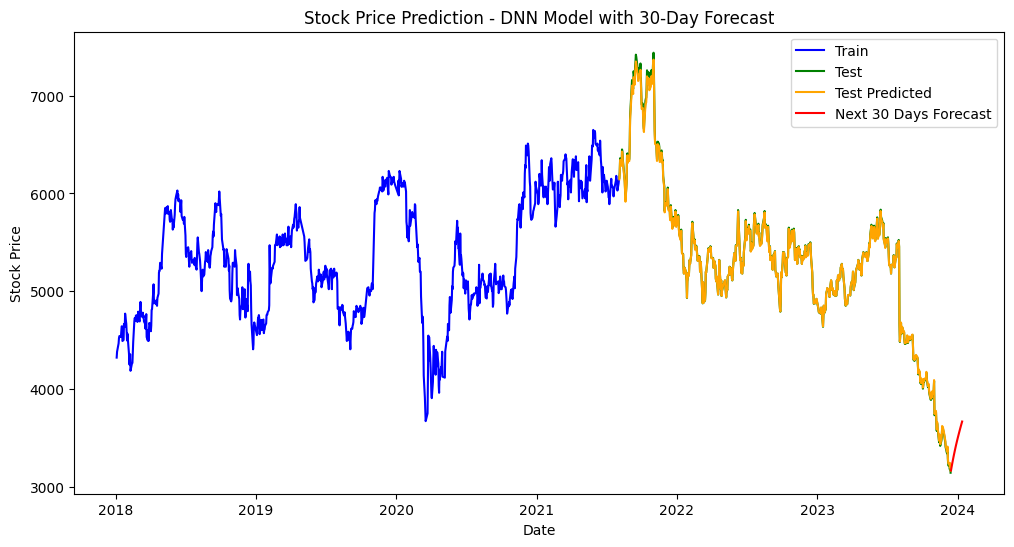

In [7]:

# Plotting the forecasted prices
plt.figure(figsize=(12, 6))
# Dữ liệu train
plt.plot(df['Date'].iloc[:len(y_train)], y_train, label='Train', color='blue')
plt.plot(df['Date'].iloc[len(y_train):len(y_train) + len(y_test)], y_test, label='Test', color='green')
plt.plot(df['Date'].iloc[len(y_train):len(y_train) + len(y_test)], y_test_pred, label='Test Predicted', color='orange')

next_30_days_index = pd.date_range(df['Date'].iloc[-1], periods=31, freq='D')[1:]
plt.plot(next_30_days_index, forecasted, label='Next 30 Days Forecast', color='red')

plt.title('Stock Price Prediction - DNN Model with 30-Day Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()